In [25]:
import os
import scipy.stats as stats
import h5py
import numpy as np
import json
from collections import OrderedDict

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
from matplotlib import rc, rcParams
import matplotlib.gridspec as gridspec

### file that has the thrown expectations

generated by running the MC with 20,000 sets of randomly generated (*assumed to be uncorrelated*) nuisance parameters, according to the fitted posterior means and widths. The 20,000 events are distributed for practical purposes among 4 files. The 5th file is only one set of histograms that contains the result for the best fit nuisance parameters

In [3]:
file1 = h5py.File('meows_files/Expectation_fluxnew_ddmnodeis_sim_BDT_Split_HE_Plus_Tau_point_0_0.000000_0.000000_0.000000_0.000000_0.000000_0.000000_seed_1_BF_posterior_uncertainty_n5000.h5', 'r')
file2 = h5py.File('meows_files/Expectation_fluxnew_ddmnodeis_sim_BDT_Split_HE_Plus_Tau_point_0_0.000000_0.000000_0.000000_0.000000_0.000000_0.000000_seed_2_BF_posterior_uncertainty_n5000.h5', 'r')
file3 = h5py.File('meows_files/Expectation_fluxnew_ddmnodeis_sim_BDT_Split_HE_Plus_Tau_point_0_0.000000_0.000000_0.000000_0.000000_0.000000_0.000000_seed_3_BF_posterior_uncertainty_n5000.h5', 'r')
file4 = h5py.File('meows_files/Expectation_fluxnew_ddmnodeis_sim_BDT_Split_HE_Plus_Tau_point_0_0.000000_0.000000_0.000000_0.000000_0.000000_0.000000_seed_4_BF_posterior_uncertainty_n5000.h5', 'r')
nominal = h5py.File('meows_files/Expectation_fluxnew_ddmnodeis_sim_BDT_Split_HE_Plus_Tau_point_0_0.000000_0.000000_0.000000_0.000000_0.000000_0.000000_seed_4_BFpoint_n1.h5', 'r')

Cleanup to get rid of unphysical entries

In [4]:
concat_exp = np.concatenate((file1['hists'], file2['hists'], file3['hists'], file4['hists']), axis=0)
concat_params = np.concatenate((file1['params'], file2['params'], file3['params'], file4['params']), axis=0)

In [5]:
indices_to_purge = []
for i in range(len(concat_exp)): 
    if np.any(concat_exp[i].flatten() > 100000): 
        indices_to_purge.append(i)
        
concat_exp = np.delete(concat_exp, indices_to_purge, axis=0)
concat_params = np.delete(concat_params, indices_to_purge, axis=0)

In [6]:
nominal_exp = nominal['hists']
nominal_params = nominal['params']

### binning scheme for the histogram

just for reference

```
steering_params.minFitEnergy                    = 300
steering_params.maxFitEnergy                    = 1e5
steering_params.logEbinEdge                     = np.log10(300)
steering_params.logEbinWidth                    = (np.log10(1e5)-np.log10(300))/24
steering_params.minCosth                        = -1
steering_params.maxCosth                        = 0.
steering_params.cosThbinEdge                    = 0.0
steering_params.cosThbinWidth                   = 0.05
```

bins are labelled as follows: 
- 1st index labels one set of generated nuisance params, 
- 2nd index labels starting or throughgoing, 
- 3rd index is costheta bin, 
- 4th index is energy bin

### For example, make a histogram of the distribution of bin counts in a particular bin. 

**Use this width to estimate uncertainty for this bin.** Not sure how you want to do this, maybe just take stdev? 

Note the skewed shape. I think this might be a result of assuming uncorrelated nuisance params and the fact that some nuisance params are gaussian but bounded by min/max values

for a given index, which labels one unique bin, plot a distribution of the bin counts. The nominal best fit value is indicated with a vertical dashed line

Text(0.5, 0, 'bin count')

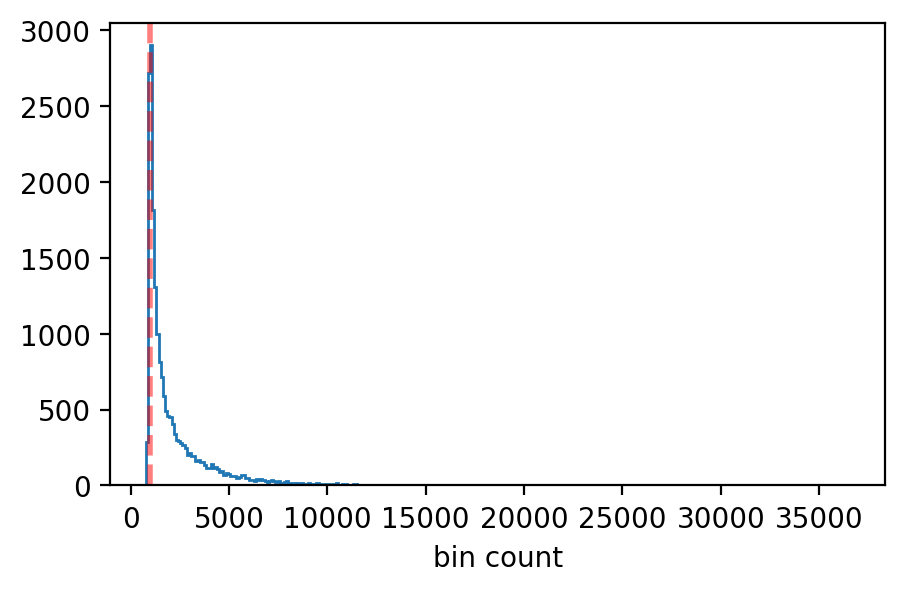

In [8]:
index = (0,0,0)

plt.figure(figsize=(5, 3),dpi=200)

entries = concat_exp[:,index[0],index[1],index[2]]

hist, bins = np.histogram(entries, bins='auto')
plt.axvline(x=nominal_exp[0,index[0],index[1],index[2]], color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.stairs(hist, bins, fill=False, linewidth=1, linestyle='-')
plt.xlabel('bin count')

## Some energy spectra for fixed cos(theta_zen)

In [26]:
fsize = 11
std_figsize = (1.2 * 3.7, 1.6 * 2.3617)
std_axes_form = [0.16, 0.15, 0.81, 0.76]

# standard figure
def std_fig(ax_form=std_axes_form, figsize=std_figsize, rasterized=False):

    rcparams = {
        "axes.labelsize": fsize,
        "xtick.labelsize": fsize,
        "ytick.labelsize": fsize,
        "figure.figsize": std_figsize,
        "legend.frameon": False,
        "legend.loc": "best",
    }
    plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"
    rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
    rc("text", usetex=True)
    rcParams.update(rcparams)
    rcParams["hatch.linewidth"] = 0.3
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes(ax_form, rasterized=rasterized)
    ax.patch.set_alpha(0.0)

    return fig, ax

def read_data(textfile):
    energies, *data = np.loadtxt(textfile, unpack=True)
    data = np.array(data).T
    return energies, data

def read_cos_energy_data(cz_index, textfile):
    with open(textfile, 'r') as file:
        blocks = file.read().strip().split('\n\n')

    if cz_index >= len(blocks) or cz_index < 0:
        raise ValueError("cz_index out of range")

    # Extracting the first column (constant value) from the first line of the block
    coszen = float(blocks[cz_index].strip().split('\n')[0].split()[0])

    # Create a temporary file to store the selected block of data without the first column
    temp_file = tempfile.NamedTemporaryFile(delete=False)
    try:
        for line in blocks[cz_index].strip().split('\n'):
            cols = line.split()
            temp_file.write(' '.join(cols[1:]).encode() + b'\n')  # Skip the first column
        temp_file.close()

        # Use the temporary file's name in read_data
        energies, data = read_data(temp_file.name)

    finally:
        os.remove(temp_file.name)  # Clean up by deleting the temporary file
    return coszen, energies, data

def create_dash_dot_pattern(dash_length, space_length, num_dots):
    pattern = [dash_length, space_length]
    for _ in range(num_dots):
        pattern.extend([1, space_length])
    return pattern



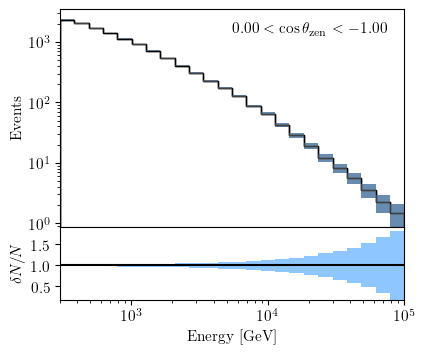

In [207]:
coszen_i = -1

Ebins = np.geomspace(300, 1e5, 24 + 1)
Ebins_c = Ebins[:-1] + np.diff(Ebins)/2

coszen_bins = np.linspace(-1, 0, 20 + 1)
coszen_bins_c = coszen_bins[:-1] + np.diff(coszen_bins)/2

norm = (Ebins_c/Ebins[0])**1.7
hist_events = nominal_exp[0][0,coszen_i]#*norm
hist_std_dev = np.sqrt(np.std(nominal_exp, axis=0)[0,coszen_i]**2 + np.sqrt(hist_events)**2)#*norm

fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax, ax_ratio = axes

ax.hist(Ebins[:-1], Ebins, weights=hist_events, histtype='step', color='black', linestyle='-', linewidth=1)
ax.bar(Ebins_c, height=hist_std_dev, width=np.diff(Ebins), bottom=hist_events - hist_std_dev/2, facecolor='dodgerblue', linestyle='', alpha=0.5)
ax.bar(Ebins_c, height=np.sqrt(hist_events), width=np.diff(Ebins), bottom=hist_events - np.sqrt(hist_events)/2, facecolor='gray', linestyle='', alpha=0.5)
# ax.errorbar(Ebins_c, hist_events, yerr=hist_std_dev/2, color='dodgerblue', linestyle='', linewidth=2, alpha=0.5)
ax.hist(Ebins[:-1], Ebins, weights=hist_events, histtype='step', color='black', linestyle='-', linewidth=1, zorder=2)

# Plot the error bars
ax.bar(Ebins_c, height=hist_std_dev, width=np.diff(Ebins), bottom=hist_events - hist_std_dev/2, facecolor='dodgerblue', linestyle='', alpha=0.5, zorder=1)
ax.bar(Ebins_c, height=np.sqrt(hist_events), width=np.diff(Ebins), bottom=hist_events - np.sqrt(hist_events)/2, facecolor='gray', linestyle='', alpha=0.5, zorder=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'Events')
ax.set_xlabel(r'Energy [GeV]')
ax.set_xlim(Ebins[0], Ebins[-1])

ax.annotate(fr'${coszen_bins[coszen_i]:.2f} < \cos \theta_{{\rm zen}} < {coszen_bins[coszen_i+1]:.2f}$', xy=(0.5,0.94), xycoords='axes fraction', ha='left', va='top', fontsize=fsize)

# Calculate the ratio hist_std_dev/hist_events
l_ratio = (hist_events - hist_std_dev) / hist_events
u_ratio = (hist_events + hist_std_dev) / hist_events

# Plot the ratio
ax_ratio.bar(Ebins_c, u_ratio - l_ratio, bottom=l_ratio, width = np.diff(Ebins), color='dodgerblue', linestyle='-', linewidth=1, alpha=0.5)
ax_ratio.axhline(1, c='black')

ax_ratio.set_xlabel(r'Energy [GeV]')
ax_ratio.set_ylabel(r'$\delta N / N$')

fig.subplots_adjust(hspace=0)
fig.savefig(f'plots/energy_spectrum_{coszen_bins[coszen_i]}.pdf', bbox_inches='tight')

### Make a histogram of the nominal best fit bin counts

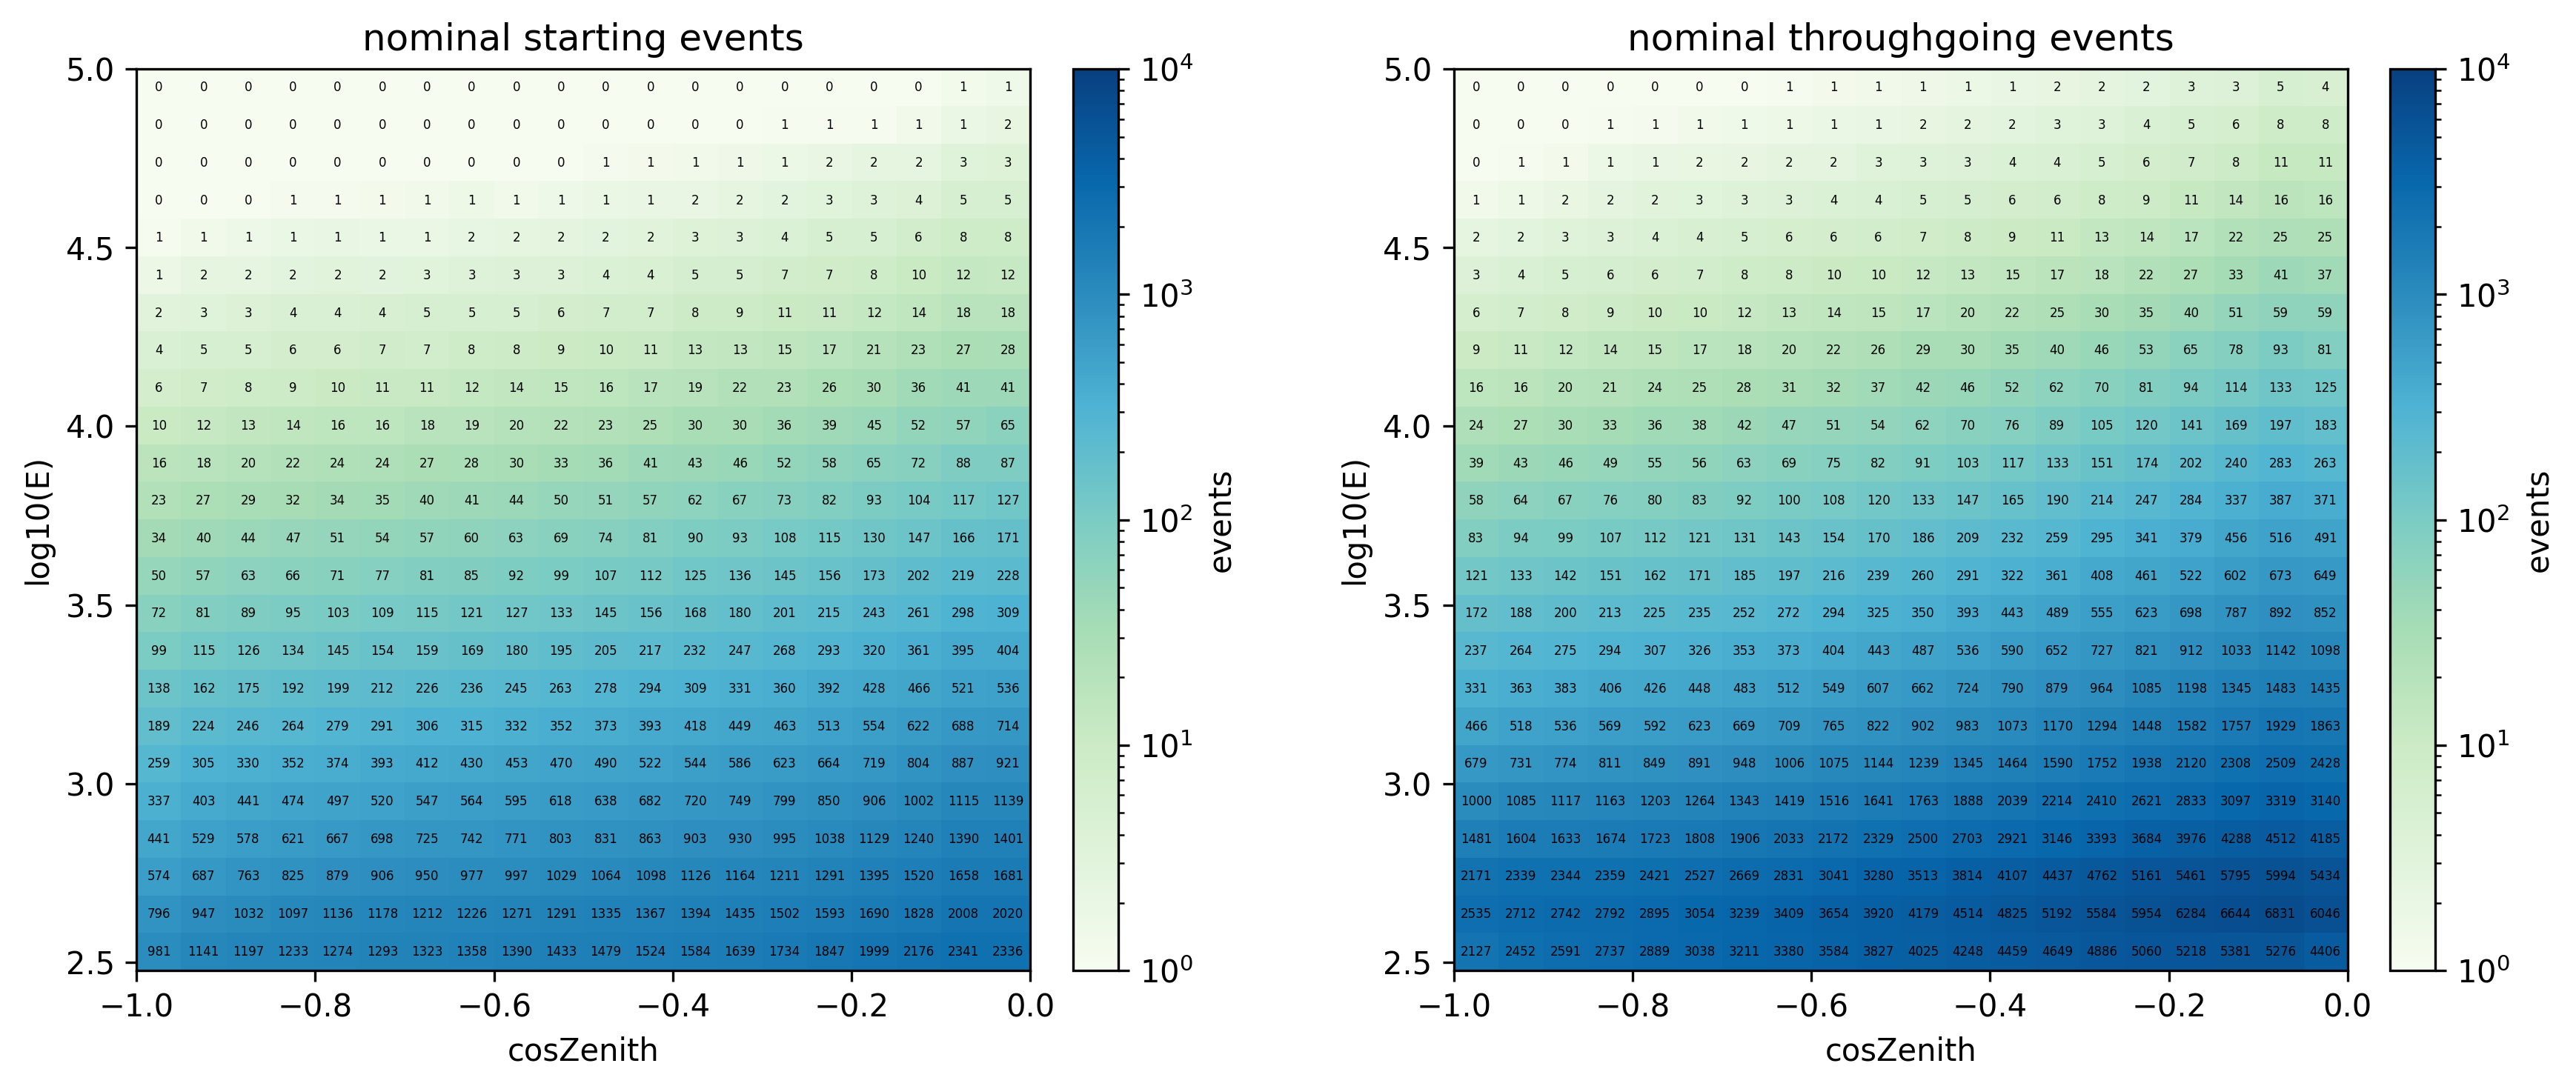

In [9]:
hist = nominal_exp[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
aspect = (0.4)
vmin=1
vmax=10000

from matplotlib.colors import LogNorm

# Create a log-scaled color map
norm = LogNorm(vmin=vmin, vmax=vmax)

# Plot the first subplot (left)
im1 = axes[0].imshow(hist[0].T, cmap='GnBu', origin='lower',extent=[-1, 0, np.log10(300), np.log10(1e5)],aspect=aspect, norm=norm)
axes[0].set_ylabel('log10(E)')
axes[0].set_xlabel('cosZenith')
#axes[0].set_aspect()  # To maintain the aspect ratio
axes[0].set_title('nominal starting events')


# Plot the second subplot (right)
im2 = axes[1].imshow(hist[1].T, cmap='GnBu', origin='lower', extent=[-1, 0, np.log10(300), np.log10(1e5)],aspect=aspect, norm=norm)
axes[1].set_ylabel('log10(E)')
axes[1].set_xlabel('cosZenith')
#axes[1].set_aspect('equal')  # To maintain the aspect ratio
axes[1].set_title('nominal throughgoing events')


# Add a colorbar to both subplots #fraction=0.046, pad=0.04
cbar1 = fig.colorbar(im1, ax=axes[0],fraction=0.046, pad=0.04, label='events')
cbar2 = fig.colorbar(im2, ax=axes[1],fraction=0.046, pad=0.04, label='events')

xedges = np.linspace(-1, 0, 20 + 1)
yedges = np.linspace(np.log10(300), np.log10(1e5), 24 + 1)

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        axes[0].text(xedges[i] + 0.5 * (xedges[i + 1] - xedges[i]),
                 yedges[j] + 0.5 * (yedges[j + 1] - yedges[j]),
                 f'{int(hist[0][i, j])}',
                 color='black',
                 ha='center',
                 va='center', fontsize=4)
        axes[1].text(xedges[i] + 0.5 * (xedges[i + 1] - xedges[i]),
                 yedges[j] + 0.5 * (yedges[j + 1] - yedges[j]),
                 f'{int(hist[1][i, j])}',
                 color='black',
                 ha='center',
                 va='center', fontsize=4)

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

### make same histogram of st dev as a estimate of uncertainty

Note: the std deviation is very high compared to the nominal bin count because of the long tails on the distributions in each bin. Perhaps a better estimate is to take the std. only for the lowest 75% of events, for example, to omit the tail and capture the width of the peak? or take the FWHM

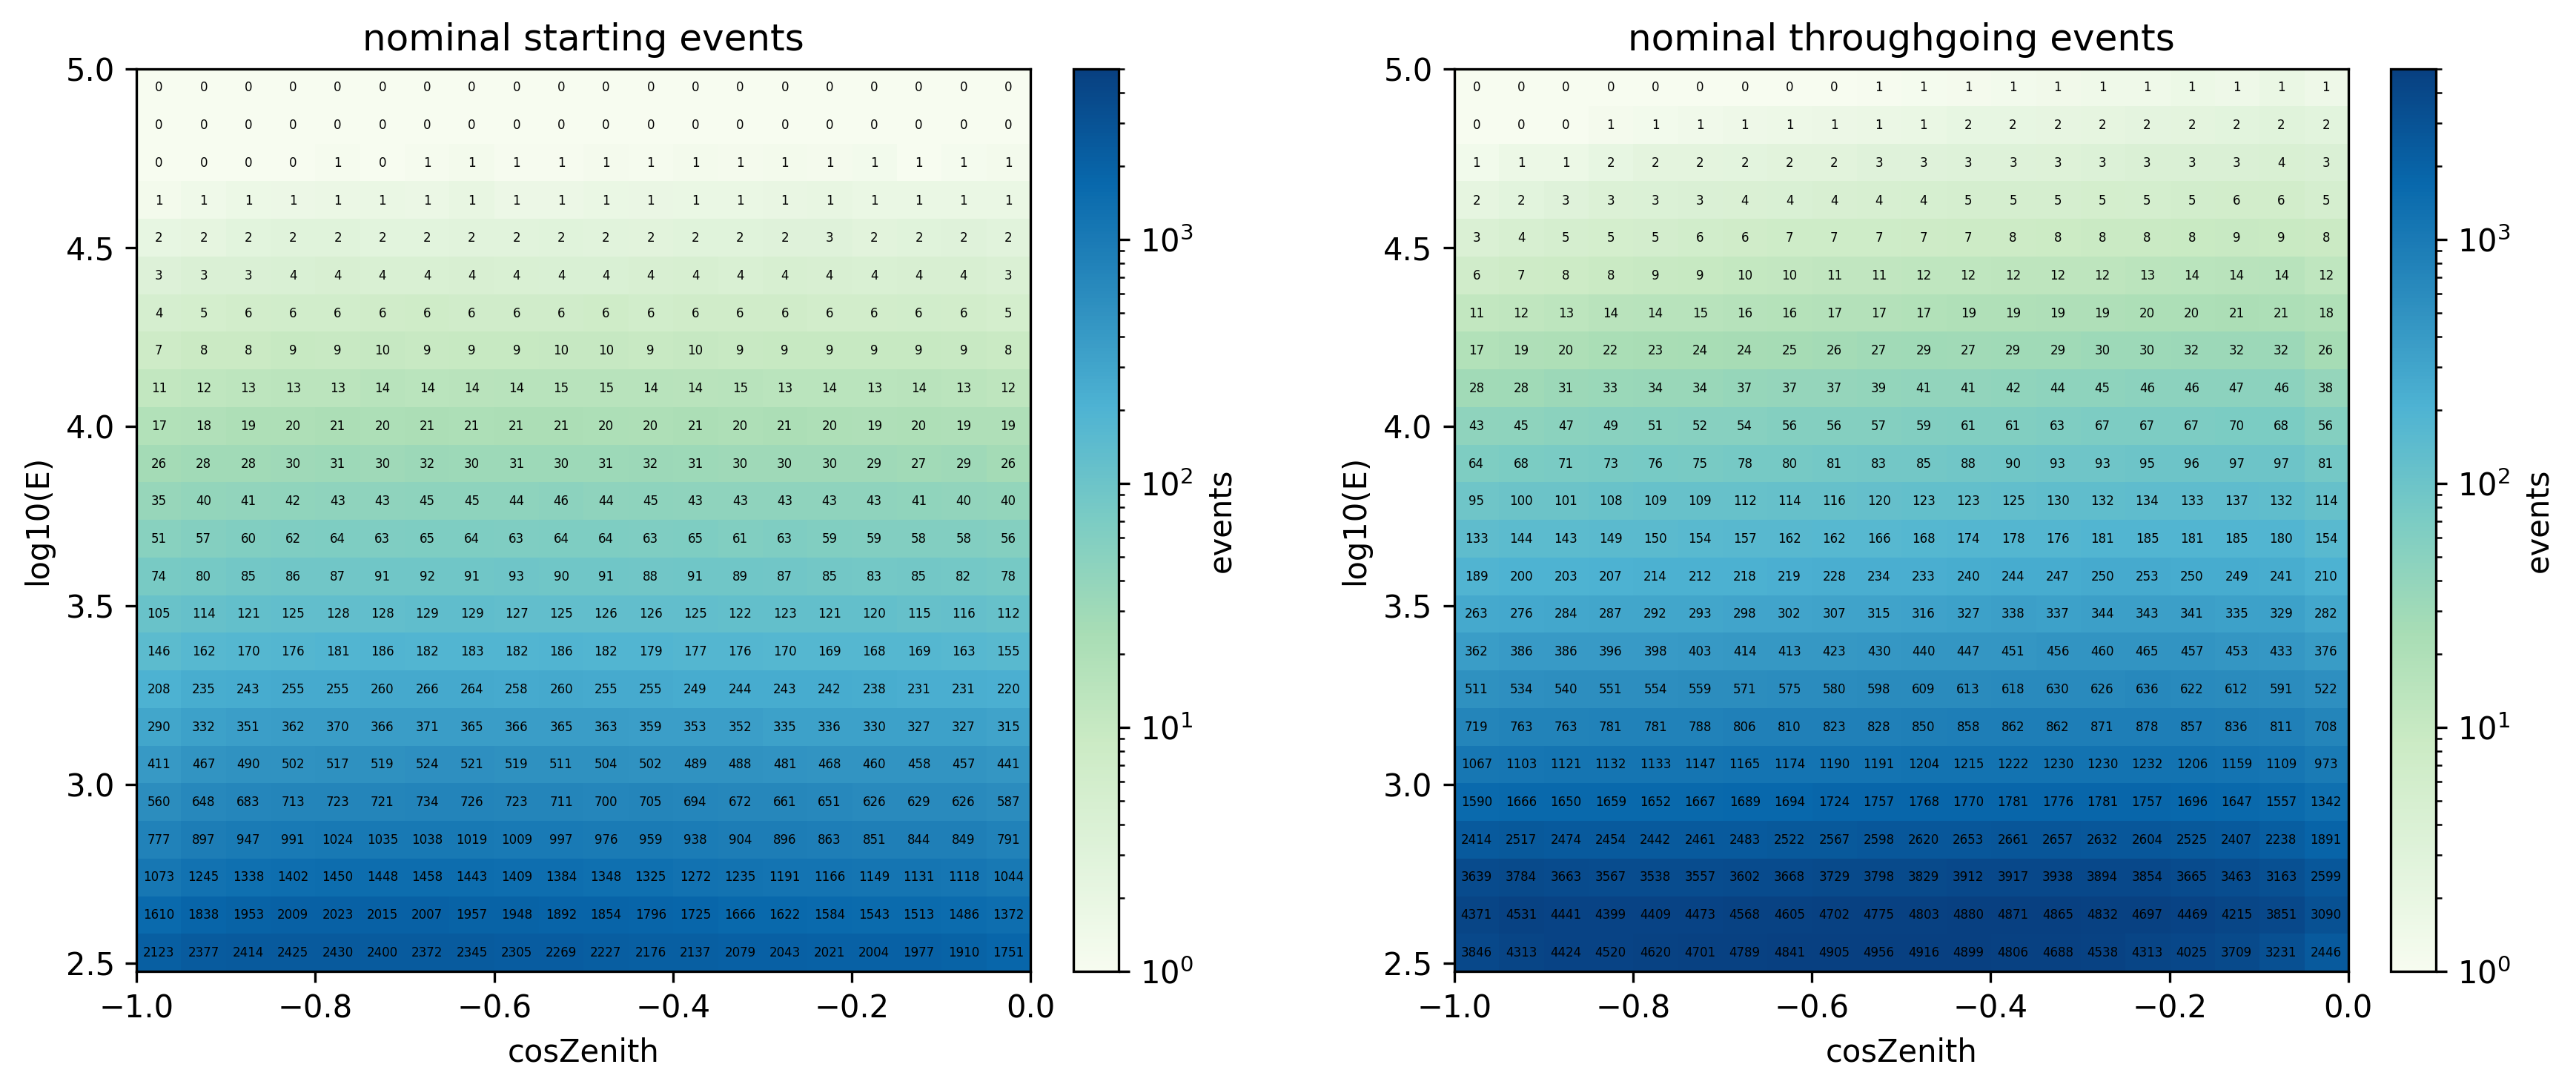

In [10]:
hist = np.std(concat_exp ,axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
aspect = (0.4)
vmin=1
vmax=5000

from matplotlib.colors import LogNorm

# Create a log-scaled color map
norm = LogNorm(vmin=vmin, vmax=vmax)

# Plot the first subplot (left)
im1 = axes[0].imshow(hist[0].T, cmap='GnBu', origin='lower',extent=[-1, 0, np.log10(300), np.log10(1e5)],aspect=aspect, norm=norm)
axes[0].set_ylabel('log10(E)')
axes[0].set_xlabel('cosZenith')
#axes[0].set_aspect()  # To maintain the aspect ratio
axes[0].set_title('nominal starting events')


# Plot the second subplot (right)
im2 = axes[1].imshow(hist[1].T, cmap='GnBu', origin='lower', extent=[-1, 0, np.log10(300), np.log10(1e5)],aspect=aspect, norm=norm)
axes[1].set_ylabel('log10(E)')
axes[1].set_xlabel('cosZenith')
#axes[1].set_aspect('equal')  # To maintain the aspect ratio
axes[1].set_title('nominal throughgoing events')


# Add a colorbar to both subplots #fraction=0.046, pad=0.04
cbar1 = fig.colorbar(im1, ax=axes[0],fraction=0.046, pad=0.04, label='events')
cbar2 = fig.colorbar(im2, ax=axes[1],fraction=0.046, pad=0.04, label='events')

xedges = np.linspace(-1, 0, 20 + 1)
yedges = np.linspace(np.log10(300), np.log10(1e5), 24 + 1)

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        axes[0].text(xedges[i] + 0.5 * (xedges[i + 1] - xedges[i]),
                 yedges[j] + 0.5 * (yedges[j + 1] - yedges[j]),
                 f'{int(hist[0][i, j])}',
                 color='black',
                 ha='center',
                 va='center', fontsize=4)
        axes[1].text(xedges[i] + 0.5 * (xedges[i + 1] - xedges[i]),
                 yedges[j] + 0.5 * (yedges[j + 1] - yedges[j]),
                 f'{int(hist[1][i, j])}',
                 color='black',
                 ha='center',
                 va='center', fontsize=4)

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

### Plot the distribution of a thrown nuisance param

plot the best fit posterior distribution of nuisance params for a given index. The actual best fit value is indicated.

The nuisance param list is indicated in the dict `bestfit_dict.json`, to find the mapping between the index and the actual name of the nuisance param

Text(0.5, 0, 'hadronicHEkm')

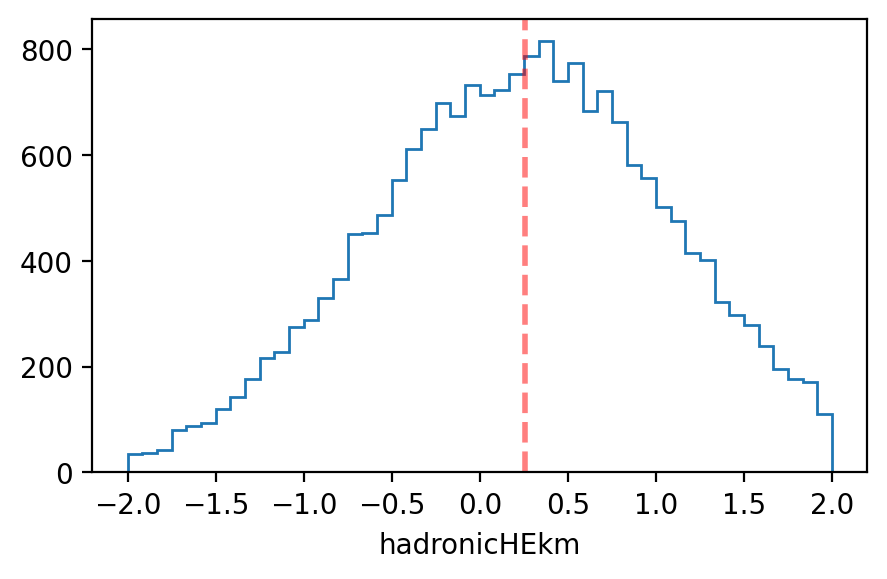

In [ ]:
index = 10

bestfit_dict = None
with open('bestfit_dict.json', 'r') as file:
    # Load the JSON data into a dictionary
    bestfit_dict = json.load(file, object_pairs_hook=OrderedDict)

data_list = list(bestfit_dict.items())
    
key, value = data_list[index]

plt.figure(figsize=(5, 3),dpi=200)

entries = concat_params[:,index]

hist, bins = np.histogram(entries, bins='auto')
plt.stairs(hist, bins, fill=False, linewidth=1, linestyle='-')
plt.axvline(x=nominal_params[0,index], color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel(key)

plot the distribution of nuisance params. The actual best fit value is indicated.

The nuisance param list is indicated in the dict `bestfit_dict.json`, to find the mapping between the index and the actual name of the nuisance param

Text(0.5, 0, 'nuisance param value')

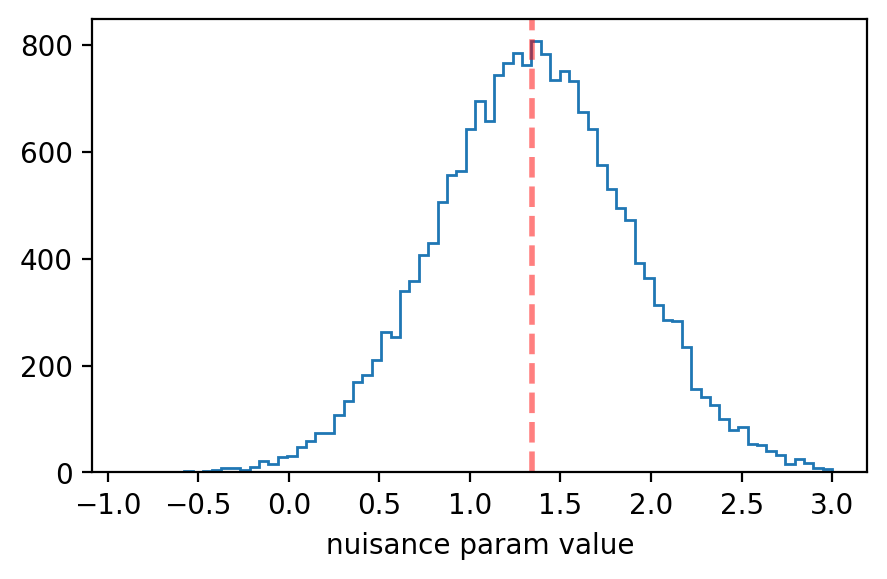

In [48]:
index = 20

plt.figure(figsize=(5, 3),dpi=200)

entries = concat_params[:,index]

hist, bins = np.histogram(entries, bins='auto')
plt.stairs(hist, bins, fill=False, linewidth=1, linestyle='-')
plt.axvline(x=nominal_params[0,index], color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('nuisance param value')